# Modelos unidimensionales

<a id='intro'></a>

Dentro del paradigma *manual* de los modelos integra-y-dispara, las versiones QIF y EIF tienen la virtud de describir potenciales de acción relativamente similares a los observados en la fisiología sin la imposición forzosa de valores de umbral. Entre otras cosas, nos es interesante la evolución *subumbral* del modelo QIF por la relación que genera entre el potencial de reposo y la corriente aplicada $I<0$. 

En esta ocasión estudiaremos a cierta profundidad esta relación, su capacidad predictiva, y la perspectiva *geométrica* con la que se pueden abordar este y otros modelos *unidimensionales*. Aprovecharemos estos aprendizajes para abordar desde el paradigma IF al modelo de Hodgkin-Huxley, que es la piedra angular de la neurociencia computacional basada en conductancias.

## Estructura del código

<a id='intro'></a>

- [Inicio](#intro)
- [Geometría del modelo QIF](#qif)
- [Teoría detrás de las líneas de fase](#teoria)
- [El modelo tridente](#tridente)
- [El modelo HHIF](#hhif)
- [Conductancias variables](#conduc)
- [El modelo de sodio persistente](#inap)
- [El modelo de FitHugh-Nagumo](#fhn)
- [Tarea 1](#tarea)

In [1]:
# Cargamos la paquetería

import numpy as np
import matplotlib.pyplot as plt
from numpy.core.function_base import linspace

from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from numpy import sqrt, exp, sin, cos

Dado que nuestro objetivo es realizar un análisis geométrico, es importante recordar qué es un campo de pendientes y cómo lo implementamos numéricamente. También implementamos una función que dibuja líneas de fase dadas una regla de evolución y un vector para la función objetivo. Cada entrada de este vector corresponderá a una flecha/punto de la línea, así que la longitud debe tomar esto en consideración al momento de definirse.

In [28]:
# Esta función grafica los campos de pendientes
# Admite tres entradas: una función que determina x'=f(t,x),
# y los vectores t, x sobre el que se grafica

def pendientes(f,t,x):
    dt = t[len(t)-1]-t[0]
    dx = x[len(x)-1]-x[0]
    if dt>dx:
        p = plt.figure(figsize=(dt/dx*7,7)) # Dimensiones de la figura
    else:
        p = plt.figure(figsize=(7,dx/dt*7))
    rt = t[1]-t[0]
    rx = x[1]-x[0]                          
    r =min(rt,rx)                           
    for j in range(len(t)):
        t0 = t[j]
        for k in range(len(x)):
            x0 = x[k]
            m = f(t0,x0)
            ti = t0-0.4*r/(sqrt(1+m**2))    # Esto define las rectas de manera que no se corten
            tf = t0+0.4*r/(sqrt(1+m**2))
            
            if m>0.001:
                
                p = plt.plot([ti,tf],[m*(ti-t0)+x0,m*(tf-t0)+x0],c="red")   # Esto grafica las rectas
                
            elif m<-0.001:
                
                p = plt.plot([ti,tf],[m*(ti-t0)+x0,m*(tf-t0)+x0],c="blue")   # Esto grafica las rectas
            
            else:
                
                p = plt.plot([ti,tf],[m*(ti-t0)+x0,m*(tf-t0)+x0],c="black")   # Esto grafica las rectas
                    
    return p

# Para modelos con diferencias considerables de dimensión entre sus ejes verticales y horizontales

def pendientes2(f,t,x):
    dt = t[len(t)-1]-t[0]
    dx = x[len(x)-1]-x[0]
    p = plt.figure(figsize=(12,6))
    rt = 12/len(t)
    rx = 6/len(x)                          
    r =min(rt,rx)                           
    for j in range(len(t)):
        t0 = t[j]
        for k in range(len(x)):
            x0 = x[k]
            m = f(t0,x0)
            ti = t0-0.4*r/(sqrt(1+m**2))    # Esto define las rectas de manera que no se corten
            tf = t0+0.4*r/(sqrt(1+m**2))
            
            if m>0.001:
                
                p = plt.plot([ti,tf],[m*(ti-t0)+x0,m*(tf-t0)+x0],c="red")   # Esto grafica las rectas
                
            elif m<-0.001:
                
                p = plt.plot([ti,tf],[m*(ti-t0)+x0,m*(tf-t0)+x0],c="blue")   # Esto grafica las rectas
            
            else:
                
                p = plt.plot([ti,tf],[m*(ti-t0)+x0,m*(tf-t0)+x0],c="black")   # Esto grafica las rectas
                    
    return p

# Línea de fase

def phase(f,x):
    
    phasep = plt.figure(figsize=(12,6))
    phasep = plt.plot(x,f(x),color="magenta")

    for k in range(len(x)):

        if f(x[k])<-0.01:

            phasep = plt.quiver(x[k],0.0,f(x[k]),0.0,color="blue")

        elif f(x[k])>0.01:

            phasep = plt.quiver(x[k],0.0,f(x[k]),0.0,color="red")

        else:

            phasep = plt.scatter([x[k]],[0.0],color="black",s=100.0)

    return phasep

# Función auxiliar de graficación

def graph(t,f):
    
    y = np.zeros(len(t))
    
    for k in range(len(t)):
        y[k] = f(t[k])
        
    return y

## Geometría del modelo QIF
<a id='qif'></a>

La evolución subumbral del modelo cuadrático está escrita por la ecuación diferencial

$$\dot{V}=V^2+I.$$
$$\dot{V}=V^2-1.$$
$$\dot{V}=V^2-4.$$

En sesiones anteriores comentamos que la propiedad de **escape en tiempo finito** implica que el potencial de membrana rebasará cualquier valor $V_{\rm max}$ dado el suficiente tiempo si la corriente aplicada es positiva. Así, la evolución subumbral es relevante solo para valores constantes y negativos de $I$, que es en lo que nos enfocaremos en esta ocasión.

In [ ]:
# Función con variable independiente (tiempo), variable dependiente (voltaje), y parámetros

def qif_param(t,V,I):
    return V**2+I

# Intensidad de corriente

I1 = -1.0

# Resolución numérica

sol = solve_ivp(qif_param, [0, 100], [0.99999, 0.99, -1.1], args=[I1], dense_output=True)

# Vector de tiempos

t = linspace(0,4,401)

# Soluciones correspondientes al vector de tiempos

u = sol.sol(t)

# Gráfica

p = plt.figure(figsize=(10,6))
p = plt.plot(t,u[1,:],c="blue",linewidth=5.0,label="V1=-1.0")
p = plt.plot(t,u[2,:],c="green",linewidth=5.0,label="V2=1.0")
p = plt.plot(t,u[0,:],c="red",linewidth=5.0,label="V0=0.0")
p = plt.legend()

p = plt.xlabel('t')
p = plt.ylabel('V')
p = plt.title("Modelo QIF, I="+str(I1)+" (subumbral)")

Notemos que, independientemente del valor inicial del potencial de membrana, a largo plazo todas las soluciones convergen a $V_{rest}=-1.0$. ¿Esto tendrá que ver con que la corriente aplicada se tomó como $I=-1.0$? ¿Qué pasa si modificamos este valor a $I=-2.0$, o $I=-4.0$?

Antes de encontrar una justificación analítica para este comportamiento, notemos cómo se comporta el campo de pendientes del modelo QIF subumbral. En particular nos interesa ver qué ocurre geométricamente con ese valor $V_{rest}$, y si hay otros puntos con esa misma propiedad.

In [ ]:
def qif(t,V):
    return V**2+I1

# Vectores de graficación del campo de pendientes

t0 = linspace(-0.5,5.0,21)
V0 = linspace(-2,2,21)

I1 = -1.0

p = pendientes(qif,t0,V0)
# p = plt.plot(t,u[1,:],c="green",linewidth=5.0,label="V1=-1.0")
# p = plt.plot(t,u[2,:],c="green",linewidth=5.0,label="V2=0.75")
# p = plt.plot(t,u[0,:],c="green",linewidth=5.0,label="V0=0.0")
p = plt.xlim([-0.5,5])

p = plt.xlabel('t')
p = plt.ylabel('V')
p = plt.title("Pendientes QIF, I="+str(I1)+" (subumbral)")

Observamos que son dos valores, $V^-_{rest}=-1.0$ y $V^+_{rest}=1.0$, los que comparten la propiedad de *producir* soluciones constantes. A este tipo de valores les llamamos *puntos de equilibrio*. De manera general, para una ecuación diferencial $\dot{x}=f(x,t)$, los puntos de equilibrio son los valores $x_0$ que satisfacen

$$\forall\,t:\dot{x}=\,f(x_0,t)=0.$$

$$\dot{V}=(-1)^2-1=1-1=0$$

Sin embargo, notamos que no dan el mismo tipo de equilibrio: uno de estos valores *atrae* soluciones, mientras que el otro las *repele*.

Otra cosa relevante del diagrama anterior es que las pendientes son independientes de la posición horizontal a la que se encuentren, es decir, solo dependen de la *altura* a la que se dibujan. Esto es propio de los *sistemas autónomos*, donde la *regla de evolución* no depende del tiempo. En ese sentido podemos pensar que el eje horizontal es redundante, y que toda la información importante sobre la evolución del sistema la podemos obtener de solo observar el eje vertical.

En lo que sigue tomaremos el eje vertical del campo de pendientes y lo colocaremos de manera horizontal. Las pendientes cambian su orientación: en vez de ir hacia arriba y hacia abajo las dibujaremos como flechas hacia la derecha o hacia la izquierda. A esta representación geométrica de una ecuación diferencial le llamaremos la *línea fase*. 

In [ ]:
I1 = -1.0

def qif_phase(V):
    return V**2+I1

V0 = linspace(-3,3,51)
phase = plt.figure(figsize=(12,6))
phase = plt.plot(V0,qif_phase(V0),color="magenta")

for k in range(len(V0)):
    
    if qif_phase(V0[k])<-0.01:
    
        phase = plt.quiver(V0[k],0.0,qif_phase(V0[k]),0.0,color="blue")
        
    elif qif_phase(V0[k])>0.01:
    
        phase = plt.quiver(V0[k],0.0,qif_phase(V0[k]),0.0,color="red")
        
    else:
        
        phase = plt.scatter([V0[k]],[0.0],color="black",s=100.0)
        
phase = plt.xlabel("V")
phase = plt.ylabel("dV/dt")
phase = plt.title("Línea de fase QIF, I="+str(I1))

La gráfica de $f(V)=V^2+I$ nos ayuda a identificar las regiones positivas y negativas de $\dot{V}$, así como los puntos de equilibrio que ocurren cuando la gráfica de $f(V)$ cruza el eje horizontal, es decir cuando $f(V)=0$.

Esta visualización nos ayuda a interpretar cualitativamente el comportamiento de las soluciones según la región de la línea fase donde coloquemos su condición inicial $V_0$. Para $I=-1.0$ observamos:

- $V_0<-1.0\,\Rightarrow$ la solución es creciente y converge a $V^-_{rest}=-1.0$
- $-1.0<V_0<1.0\,\Rightarrow$ la solución es decreciente, converge a $V^-_{rest}=-1.0$, y se aleja de $V^+_{rest}=1.0$
- $V>1.0\,\Rightarrow$ la solución es creciente y diverge a $\infty$.

Ahora que este comportamiento está (optimistamente) entendido, intentemos pensar en qué ocurre con los casos $I=0.0$ e $I=1.0$.

In [ ]:
I1 = 0.0

def qif(t,V):
    return V**2+I1

# Vectores de graficación del campo de pendientes

t0 = linspace(-0.5,5.0,21)
V0 = linspace(-2,2,21)

p = pendientes(qif,t0,V0)
p = plt.xlim([-0.5,5])

p = plt.xlabel('t')
p = plt.ylabel('V')
p = plt.title("Pendientes QIF, I="+str(I1)+" (subumbral)")

A continuación usamos la función de fase que definimos antes para dibujar la dinámica del campo vectorial sobre la recta real. A estos diagramas les conocemos como *líneas de fase*.

In [ ]:
def phase(f,x):
    
    phasep = plt.figure(figsize=(12,6))
    phasep = plt.plot(x,f(x),color="magenta")

    for k in range(len(x)):

        if f(x[k])<-0.01:

            phasep = plt.quiver(x[k],0.0,f(x[k]),0.0,color="blue")

        elif f(x[k])>0.01:

            phasep = plt.quiver(x[k],0.0,f(x[k]),0.0,color="red")

        else:

            phasep = plt.scatter([x[k]],[0.0],color="black",s=100.0)

    return phasep

In [ ]:
def qif_phase(V):
    return V**2+I1

V0 = linspace(-2,2,41)
phasep = phase(qif_phase,V0)
        
phasep = plt.xlabel("V")
phasep = plt.ylabel("dV/dt")
phasep = plt.title("Línea fase QIF, I="+str(I1))

In [ ]:
I1 = 1.0

def qif(t,V):
    return V**2+I1

# Vectores de graficación del campo de pendientes

t0 = linspace(-0.5,5.0,21)
V0 = linspace(-2,2,21)

p = pendientes(qif,t0,V0)
p = plt.xlim([-0.5,5])

p = plt.xlabel('t')
p = plt.ylabel('V')
p = plt.title("Pendientes QIF, I="+str(I1)+" (subumbral)")

In [ ]:
def phase(f,x):
    
    phasep = plt.figure(figsize=(12,6))
    phasep = plt.plot(x,f(x),color="magenta")

    for k in range(len(x)):

        if f(x[k])<-0.01:

            phasep = plt.quiver(x[k],0.0,f(x[k]),0.0,color="blue")

        elif f(x[k])>0.01:

            phasep = plt.quiver(x[k],0.0,f(x[k]),0.0,color="red")

        else:

            phasep = plt.scatter([x[k]],[0.0],color="black",s=100.0)

    return phasep

I1 = 1.0

def qif_phase(V):
    return V**2+I1

V0 = linspace(-2,2,41)
phasep = phase(qif_phase,V0)

phasep = plt.xlabel("V")
phasep = plt.ylabel("dV/dt")
phasep = plt.title("Línea fase QIF, I="+str(I1))

Tal como observamos, en el caso $I=0.0$ tenemos un único equilibrio, $V_{rest}=0.0$, y a este valor convergen las soluciones con condición inicial negativa, mientras que las soluciones con condición inicial positiva divergen a $\infty$. En el caso $I=1.0$ no hay puntos de equilibrio y todas las soluciones se mantienen crecientes y divergentes a $\infty$. Ésta es precisamente la propiedad de **escape en tiempo finito**, pues cualquier solución para $I>0$ diverge a infinito y supera cualquier valor $V_{max}$ puesto durante la observación. Algo similar ocurre en el caso $I=0.0$, donde las soluciones positivas son divergentes y las negativas convergen al reposo.

[Regresar](#intro)

## Teoría detrás de las líneas de fase
<a id='teoria'></a>

Un par de preguntas relacionadas surgen con el análisis anterior. 

- ¿Por qué a falta de puntos de equilibrio las soluciones son divergentes?
- ¿Por qué las soluciones no pueden cruzar los puntos de equilibrio?

Para responder a la primera, intuitivamente podemos pensar que si una solución $V(t)$ converge a alguna constante $k\in\mathbb{R}$, entonces por continuidad este valor $k$ debe ser un punto de equilibrio (dado que cerca de ahí las pendientes deben ser más y más horizontales). Así, los sistemas sin puntos de equilibrio no tienen valores constantes a los qué converger, y por continuidad solo pueden crecer indefinidamente o decrecer indefinidamente.

Responder a la segunda cuestión requiere de un argumento más fino pero se reduce a una propiedad fundamental (pero no trivial) de los sistemas definidos por ecuaciones diferenciales. Esta propiedad está planteada en el **Teorema de Existencia y Unicidad** y dice, en términos sencillos, lo siguiente:

**Teorema (Existencia y Unicidad)** Dada una ecuación diferencial $\dot{x}(t)=f(t,x)$, para toda condición inicial $(t_0,x_0)$ **existe una única solución** $x(t)$ a la ecuación diferencial tal que $x(t_0)=x_0$.

Dos soluciones distintas a una misma ecuación diferencial no se pueden intersecar. En caso de que se intersecaran podemos tomar ese punto de intersección como una nueva condición inicial para garantizar que, al menos a partir de la intersección, las dos soluciones deben ser iguales, por lo que también en el pasado son iguales.

En particular, los puntos de equilibrio engendran soluciones constantes. Cualquier solución que no corresponda a un punto de equilibrio, por fuerza del TEU, no puede cruzar la solución constante. Lo más que puede ocurrir es que acerque *asintóticamente* pero sin tocar al valor constante. Éste es el comportamiento observado en el modelo QIF subumbral, $I=-1.0$, para el reposo $V^-_{rest}=-1.0$.

[Regresar](#intro)

## Ejemplo: El modelo tridente
<a id='tridente'></a>

Más adelante en el curso encontraremos cierto uso para los modelos en EDOs donde la regla de evolución mantiene una dependencia *cúbica* del potencial de membrana. La versión más sencilla de este modelo toma la forma

$$\dot{V}=V-\tfrac{1}{3}V^3.$$

Solo por darle un nombre, a esta ecuación diferencial le llamaremos el *modelo tridente (pitchfork)*. Veamos cómo se comportan el campo de pendientes y la línea fase en este caso.

In [ ]:
def pitch_sol(t,V):
    return V-V**3/3

# Vectores de graficación del campo de pendientes

t0 = linspace(-0.5,5.0,21)
V0 = linspace(-2,2,31)

# Resolución numérica

sol = solve_ivp(pitch_sol, [0, 5], [0.1, -0.1], dense_output=True)

# Vector de tiempos

t = linspace(0,5,501)

# Soluciones correspondientes al vector de tiempos

u = sol.sol(t)

# Gráfica

p = plt.figure(figsize=(12,6))

p = pendientes(pitch_sol,t0,V0)
p = plt.xlim([-0.5,5])

p = plt.xlabel('t')
p = plt.ylabel('V')
p = plt.title("Pendientes tridente")

p = plt.plot(t,u[0,:],c="green",linewidth=5.0)
p = plt.plot(t,u[1,:],c="green",linewidth=5.0)

In [ ]:
def pitch_phase(V):
    return V-V**3/3

V0 = linspace(-2,2,51)
phasep = phase(pitch_phase,V0)

phasep = plt.xlabel("V")
phasep = plt.ylabel("dV/dt")
phasep = plt.title("Línea de fase tridente")

Este modelo no tiene soluciones divergentes. **¿Cuántos comportamientos a largo plazo podemos observar?**

[Regresar](#intro)

## Ejemplo: El modelo HHIF
<a id='hhif'></a>

En su trabajo seminal de 1952, A. Hodgkin y A. Huxley plantean una descripción del axón gigante de calamar basándose en circuitos RC. Su modelo integra tres corrientes iónicas: una corriente de sodio $I_{Na}$, una de potasio $I_K$ y una de fuga $I_L$. La versión IF de este modelo queda escrita como

$$V(t)=\begin{cases}
C\dot{V}=I-g_{Na}(V-E_{Na})-g_K(V-E_K)-g_L(V-E_L)&:\, V(t)\leq V_{th},\\
V\to V_{reset}&:\,V(t)>V_{th}.
\end{cases} $$

Lo que afirmamos en esta ocasión es que si las tres conductancias $g_{Na}$, $g_K$ y $g_L$ se mantienen constantes, es decir, si las tres corrientes iónicas son *óhmicas*, entonces no es posible que este modelo genere potenciales de acción sin el mecanismo IF. Este argumento se basa en que, cualitativamente, la evolución subumbral de este modelo es suficientemente similar a otro modelo que ya estudiamos.

In [ ]:
# Conductancias

gNa = 0.0
gK = 0.0
gL = 0.3

# Potenciales de reversión

ENa = 63.54
EK = -74.16
EL = -54.3

# Corriente aplicada

I1 = 10.0
# I1 = 1000.0

# Regla de evolución

def HH_sol(t,V,I):
    return I-gNa*(V-ENa)-gK*(V-EK)-gL*(V-EL)

def HH(t,V):
    return HH_sol(t,V,I1)

# Vectores de graficación del campo de pendientes

t0 = linspace(-0.5,5.0,41)
V0 = linspace(EK,ENa,31)

# Resolución numérica

sol = solve_ivp(HH_sol, [0, 10], [ENa, EK], args  = [I1], dense_output=True)

# Vector de tiempos

t = linspace(0,10,501)

# Soluciones correspondientes al vector de tiempos

u = sol.sol(t)

# Gráfica

p = plt.figure(figsize=(12,6))

p = pendientes2(HH,t0,V0)
p = plt.xlim([-0.5,5])

p = plt.xlabel('t')
p = plt.ylabel('V')
p = plt.title("Pendientes HHIF")

p = plt.plot(t,u[0,:],c="green",linewidth=5.0)
p = plt.plot(t,u[1,:],c="green",linewidth=5.0)

Observemos que al poner $g_{Na}=0.0$, $g_{K}=0.0$ regresamos al modelo LeakIF (subumbral) con corriente constante. Este modelo tenía definido un potencial de reposo, así que, razonablemente, el modelo HHIF tiene también un reposo determinado por los parámetros relevantes del sistema. En la gráfica anterior podemos convencernos que ese reposo coincide con el (único) punto de equilibrio. El hecho de que este equilibrio es único será tema de discusión **(tarea)**.

Dado que observamos un único cambio de signo en el campo de pendientes, podemos esperar que la línea fase también sea relativamente sencilla.

In [ ]:
def HH_phase(V):
    return HH(0.0,V)

phasep = phase(HH_phase,V0)

phasep = plt.xlabel("V")
phasep = plt.ylabel("dV/dt")
phasep = plt.title("Línea fase HHIF")

Casi sorprendentemente, la gráfica que da al modelo HH no es otra cosa que una línea recta que cruza al eje horizontal en algún punto que identificamos con $V_{rest}$. Podemos ver que las soluciones con condición inicial menor a $V_{rest}$ son crecientes, y que aquéllas con condición inicial mayor a $V_{rest}$ son decrecientes. En virtud del **TEU**, las soluciones no pueden cruzar a la solución constante $V_0(t)=V_{rest}$, por lo que su única opción es converger asintóticamente a $V_{rest}$. Así es que podemos decir que los modelos LeakIF y HHIF tienen un potencial de reposo definido, y que éste depende de las conductancias, de los potenciales de reversión, ¡y de la corriente aplicada!

Sin embargo, esta discusión termina con una nota relativamente triste. De todos los modelos IF discutidos en este tema, el más *cercano* a la biología por su planteamiento es el modelo HHIF. El análisis anterior implica que, a falta de variación en la corriente aplicada, los modelos subumbrales solo pueden generar soluciones que diverjan o que converjan a un valor de reposo. Puesto que las soluciones solo pueden ser siempre crecientes, siempre decrecientes, o siempre constantes, **esto imposibilita la existencia de comportamientos oscilatorios o periódicos.**

Esto es: **los modelos subumbrales no pueden producir potenciales de acción**. ¡La componente manual de los modelos IF es *necesaria* para dibujar espigas! Como veremos más adelante, esto es un problema resultado de la simplicidad de nuestras reglas de evolución, y solo se soluciona incrementando las *dimensiones*... sea lo que sea que eso quiera decir.

[Regresar](#intro)

## Conductancias variables
<a id='conduc'></a>

La conclusión del tema anterior es que los modelos 1D subumbrales no pueden exhibir potenciales de acción ni comportamientos oscilatorios de manera autónoma, es decir, sin estímulos que varíen con el tiempo (como los esquemas IF o las corrientes no-constantes). Un paso intermedio entre este paradigma y la versión más completa de los modelos basados en conductancia, como Hodgkin-Huxley, es incorporar las variaciones de la permeabilidad de la membrana neuronal dentro de nuestros modelos mediante las conductancias.

El primer modelo que veremos se basa en la idea de conductancias variables, esto es, que la densidad de las corrientes iónicas varía con el tiempo. De manera general se supone que las conductancias de una corriente se ven de la forma

$$g_i=\bar{g}_im_i^{a_i}h_i^{b_i},$$

donde $g_i$ es la conductancia (total) de la corriente iónica, $\bar{g}_i$ es la conductancia *maximal* 
de la corriente, $m_i$ es una variable de activación, $h_i$ es una variable de inactivación, que en conjunto representan la proporción de canales abiertos, y $a_i$ y $b_i$ representan el número de compuertas de activación e inactivación, respectivamente. En este momento suponemos que los canales están regulados por voltaje (*voltage-gated*), por lo que las activaciones e inactivaciones son dependientes de $V$. Si un canal no tiene compuertas de inactivación ($b=0$) decimos que la corriente asociada es *persistente*. En caso contrario, decimos que es *transitoria*.

Por el momento estudiaremos corrientes persistentes, así que la conductancia se reduce a

$$g_i = \bar{g}_im_i^{a_i}.$$

Un valor $m_i=1$ quiere decir que la conductancia alcanza su valor máximo, por lo que la corriente está completamente *activada*. Por su parte, valores $0<m_i<1$ implican que la corriente está parcialmente activada, mientras que $m_i=0$ reduce la conductancia a $g_i=0$, y se dice que la corriente está *desactivada*. 

Cuando una corriente no contempla compuertas de activación ($a_i=0$) ni inactivación ($b_i=0$) se concluye que la conductancia se mantiene constante a lo largo del tiempo, $g_i=\bar{g}_i$. Estas corrientes son denominadas *óhmicas*, o *de fuga*, y su papel es ayudar al potencial de membrana a alcanzar el reposo.

[Regresar](#intro)

## Modelo de sodio persistente
<a id='inap'></a>

Consideremos el modelo

$$C\dot{V}=I-g_L(V-E_L)-\bar{g}_{Na}m_{\infty}(V)(V-E_{Na}),$$

donde $I_L=g_L(V-E_L)$ es una corriente de fuga, y $I_{Na}=\bar{g}_{Na}m_{\infty}(V)(V-E_{Na})$ es una corriente persistente de sodio de activación instantánea, con función de activación

$$m_{\infty}(V)=\dfrac{1}{1+\exp\left(\tfrac{V_{1/2}-V}{\Delta}\right)},$$

que es una función tipo-Boltzmann, donde $V_{1/2}$ es la activación media de la corriente, y $\Delta$ es la pendiente de la activación en $V=0$. Por todas estas características, a este modelo se le conoce como el **modelo de sodio persistente de activación instantánea con fuga**, o $I_{Na_p,L}$.

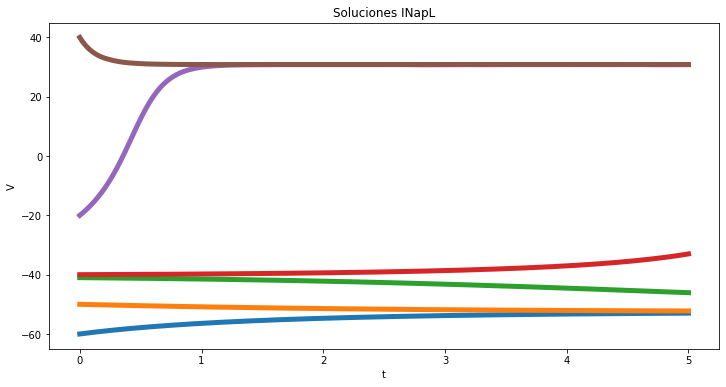

In [3]:
### Capacidad eléctrica

C = 10.0

### Conductancias maximales

gNa = 74.0
gL = 19.0

### Potenciales de reversión

ENa = 60.0
EL = -67.0

### Parámetros de la activación instantánea

Vh = 1.5
Del = 16.0

### Función de activación instantánea

def minf(V):
    return 1/(1+exp((Vh-V)/Del))

### Corriente aplicada

I1 = 0.0

def Iapp(t):
    return I1

### Campo vectorial

def INapL_app(t,V):
    return (Iapp(t)-gL*(V-EL)-gNa*minf(V)*(V-ENa))/C

### Integración numérica. Seis soluciones.

t = linspace(0,5,501)
V0 = [-60.0,-50.0,-41.0,-40.0,-20.0,40.0]
sol = solve_ivp(INapL_app, [0, 5], V0, dense_output=True)
u = sol.sol(t)

p = plt.figure(figsize=(12,6))
p = plt.xlabel('t')
p = plt.ylabel('V')
p = plt.title("Soluciones INapL")

p = plt.plot(t,u[0,:],linewidth=5.0)
p = plt.plot(t,u[1,:],linewidth=5.0)
p = plt.plot(t,u[2,:],linewidth=5.0)
p = plt.plot(t,u[3,:],linewidth=5.0)
p = plt.plot(t,u[4,:],linewidth=5.0)
p = plt.plot(t,u[5,:],linewidth=5.0)

Con las soluciones anteriores podemos suponer la existencia de dos puntos de equilibrio estables, uno más despolarizado que el otro, así como un punto inestable. Verifiquemos esto mediante la gráfica del campo vectorial y mediante la línea fase.

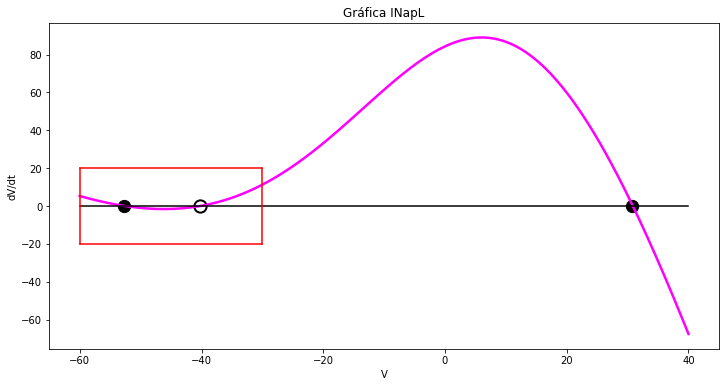

In [4]:
### Gráfica del campo vectorial

I1 = 0.0

def INapL_phase(V):
    return (I1-gL*(V-EL)-gNa*minf(V)*(V-ENa))/C

V = linspace(-60,40,10001)

p = plt.figure(figsize=(12,6))
p = plt.plot(V,INapL_phase(V),linewidth=2.5,color="magenta")
p = plt.plot([-60,40],[0,0],color="black")
p = plt.scatter([-40.3],[0.0],s=150,color="white",edgecolors="black", linewidth=2.0,alpha=1.0)
p = plt.scatter([-52.8,30.8],[0.0,0.0],s=150,color="black")

p = plt.plot([-60,-30],[-20,-20],color="red")
p = plt.plot([-60,-30],[20,20],color="red")
p = plt.plot([-30,-30],[-20,20],color="red")
p = plt.plot([-60,-60],[-20,20],color="red")

p = plt.xlabel('V')
p = plt.ylabel('dV/dt')
p = plt.title("Gráfica INapL")

En negro marcamos los puntos de equilibrio estables, mientras que en blanco marcamos el punto inestable. Esto es consistente con las soluciones de la gráfica anterior.

En el recuadro rojo podemos observar una pequeña equivalencia dinámica entre el modelo $I_{Na_p,L}$ y el modelo QIF, versión subumbral.

Aunque no tenemos una expresión concreta para los ceros del campo vectorial, podemos estimarlos gráficamente y verificar su estabilidad mediante el criterio discutido.

In [5]:
def dINapL(V):
    return 1/C*(-gL-gNa*minf(V)-gNa/Del*exp((Vh-V)/Del)/(1+exp((Vh-V)/Del))**2)

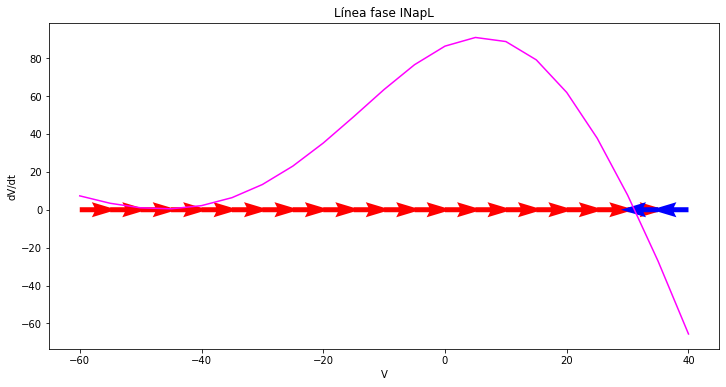

In [15]:
### Línea fase

# I1 = -1000.0
# I1 = -10.0
# I1 = 10.0
I1 = 20.0 

def INapL_phase(V):
    return (I1-gL*(V-EL)-gNa*minf(V)*(V-ENa))/C

V0 = linspace(-60,40,21)

pphase = phase(INapL_phase,V0)

p = plt.xlabel('V')
p = plt.ylabel('dV/dt')
p = plt.title("Línea fase INapL")

¿Qué ocurre si incrementamos la corriente aplicada? Geométricamente esto querría decir que *subimos* la gráfica del campo vectorial, lo que podría implicar que solo se cruce una vez (en lugar de tres) al eje $X$. Esto reduce el número de puntos de equilibrio de tres a uno, y se da convergencia global al estado despolarizado.

In [ ]:
### Gráfica del campo vectorial

I1 = 30.0

def INapL_phase(V):
    return (I1-gL*(V-EL)-gNa*minf(V)*(V-ENa))/C

V = linspace(-60,40,10001)

p = plt.figure(figsize=(12,6))
p = plt.plot(V,INapL_phase(V),linewidth=2.5,color="magenta")
p = plt.plot([-60,40],[0,0],color="black")
# p = plt.scatter([-40.3],[0.0],s=150,color="white",edgecolors="black", linewidth=2.0,alpha=1.0)
p = plt.scatter([31.2],[0.0],s=150,color="black")

p = plt.plot([-60,-30],[-20,-20],color="red")
p = plt.plot([-60,-30],[20,20],color="red")
p = plt.plot([-30,-30],[-20,20],color="red")
p = plt.plot([-60,-60],[-20,20],color="red")

p = plt.xlabel('V')
p = plt.ylabel('dV/dt')
p = plt.title("Gráfica INapL")

In [ ]:
### Línea fase

V0 = linspace(-60,40,21)

pphase = phase(INapL_phase,V0)
pphase = plt.xlabel('V')
pphase = plt.ylabel('dV/dt')
pphase = plt.title("Línea fase INapL")

En esta última gráfica vemos cómo podemos *switchear* el potencial de membrana del reposo hiperpolarizado al reposo despolarizado por una corriente *instantánea* suficientemente grande. Se puede observar que el *switcheo* contrario es más complicado, pero teóricamente posible, dada la despolarización de la membrana. En este sentido, la separatriz actúa como un *umbral* para el sistema.

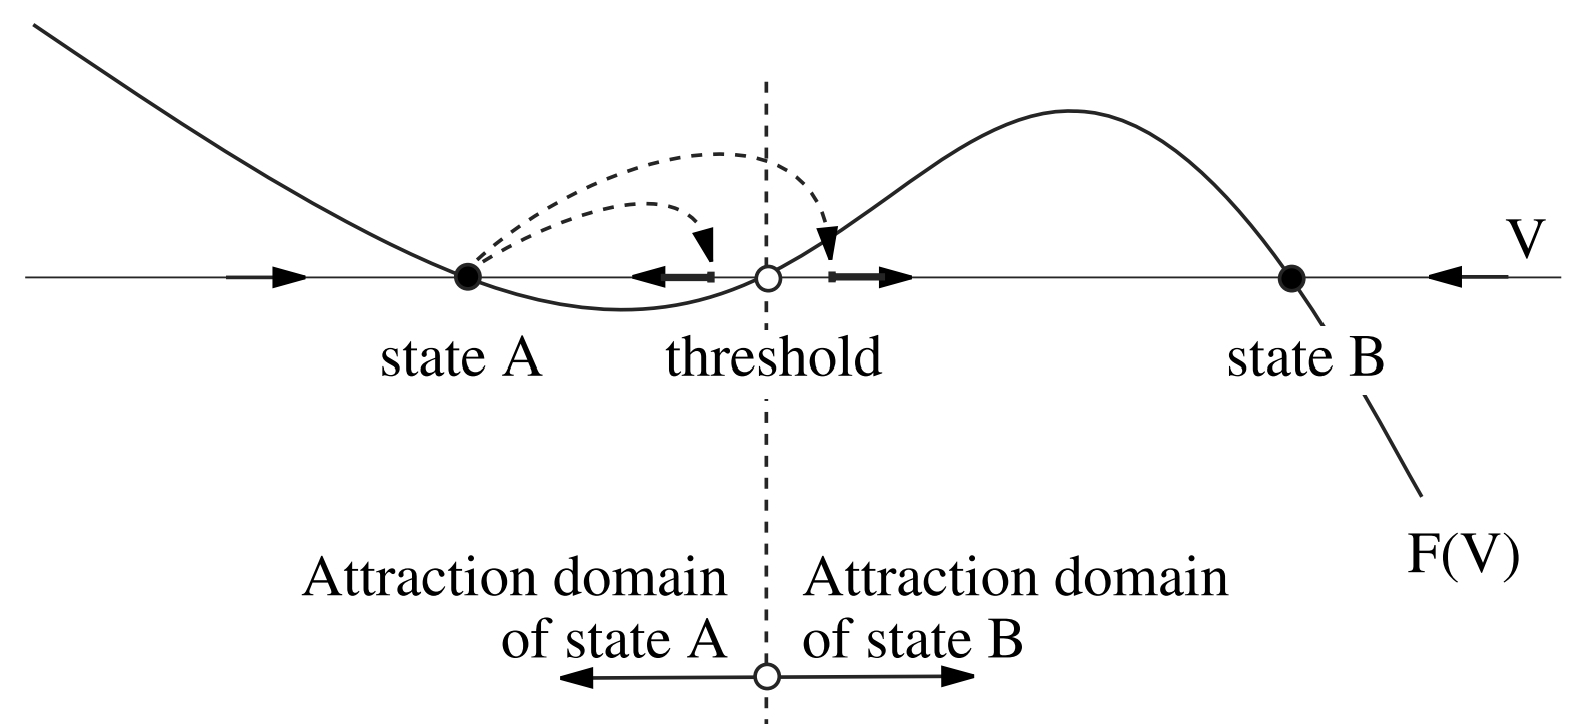

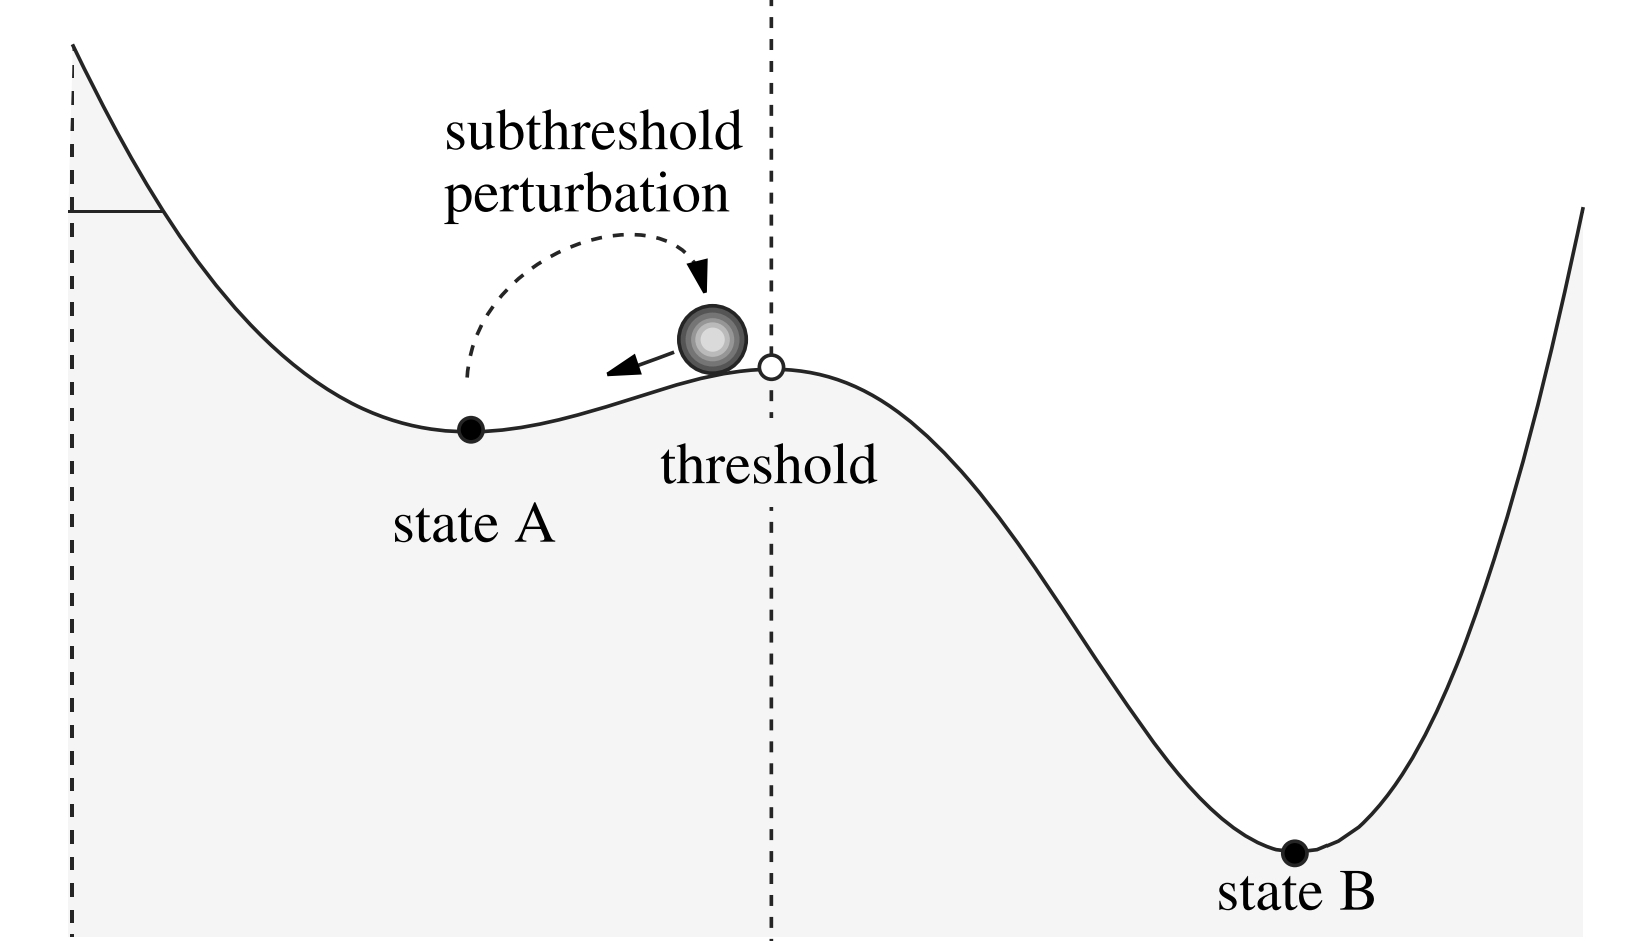

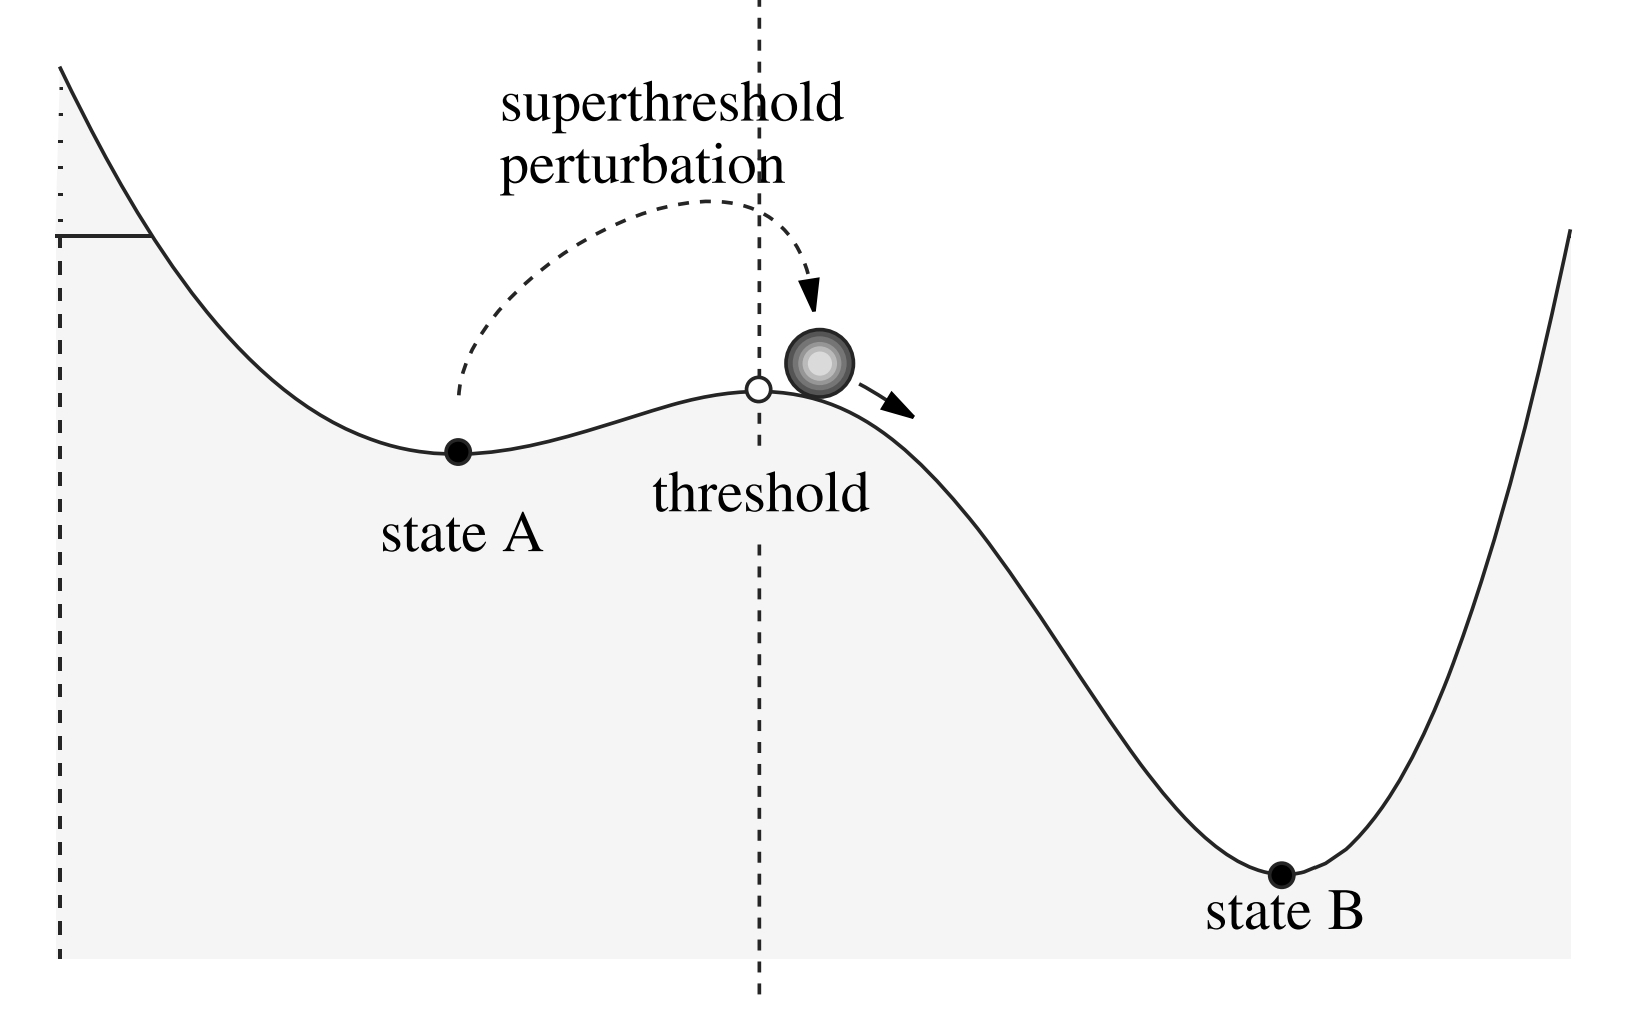

In [ ]:
def Iapp(t):
    return 100*(t>=3 and t<=3.5)

def INapL_app(t,V):
    return (Iapp(t)-gL*(V-EL)-gNa*minf(V)*(V-ENa))/C

### Integración numérica. Seis soluciones.

t = linspace(0,5,501)
V0 = [-41.0]
sol = solve_ivp(INapL_app, [0, 5], V0, dense_output=True)
u = sol.sol(t)

fig, axs = plt.subplots(2,1,figsize=(12,6), gridspec_kw={'height_ratios': [2,1]})
fig.suptitle("Switcheo INapL")

axs[0].set_ylabel('V')
axs[0].set_ylim([-60,40])

axs[0].plot(t,u[0,:],linewidth=5.0)

axs[1].plot(t,graph(t,Iapp),color="blue")
axs[1].set_xlabel('t')
axs[1].set_ylabel('I')


[Regresar](#intro)

## Modelo FitzHugh-Nagumo (recuperación instantánea, o 1D)
<a id='fhn'></a>

El modelo de FitzHugh-Nagumo (1955, y 1961 por su planteamiento como circuito equivalente) surge como una reducción geométrica del modelo de Hodgkin-Huxley, es decir que busca capturar la parte esencial de la evolución de membrana sin prestar atención a las particularidades de la escala o de la estructura matemática. Lo relevante es la similitud con que el potencial de membrana evoluciona: la ausencia o existencia de equilibrios y de umbrales, de manera cualitativa más que cuantitativa.

En esta ocasión solo estudiaremos la versión *unidimensional* del modelo (en contraste con el planteamiento original de FitzHugh, que analizaremos más adelante). Este modelo toma la forma

$$\dot{V}=\beta V-\dfrac{V^3}{3}+I,$$

donde $\beta$ es un parámetro de pendiente, e $I$ es la corriente aplicada. Como veremos a continuación, la evolución del modelo FHN(1D) y del modelo $I_{Na_p,L}$ es esencialmente la misma, tomando como punto de comparación la forma de la gráfica de los campos vectoriales (nuevamente, ignorando la escala).

Text(0, 0.5, 'I')

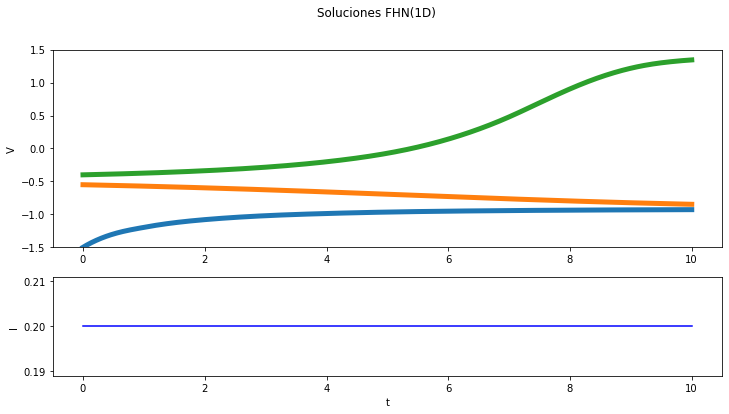

In [20]:
### Parámetros

beta = 0.5
I1 = 0.2

### Corriente aplicada

def Iapp(t):
    return I1

### Campo vectorial

def FHN_app(t,V):
    return beta*V-V**3/3+Iapp(t)

### Integración numérica. Tres soluciones.

t = linspace(0,10,501)
V0 = [-1.5,-0.55,-0.4]
sol = solve_ivp(FHN_app, [0, 10], V0, dense_output=True)
u = sol.sol(t)

fig, axs = plt.subplots(2,1,figsize=(12,6), gridspec_kw={'height_ratios': [2,1]})
fig.suptitle("Soluciones FHN(1D)")

axs[0].set_ylabel('V')
axs[0].set_ylim([-1.5,1.5])

axs[0].plot(t,u[0,:],linewidth=5.0)
axs[0].plot(t,u[1,:],linewidth=5.0)
axs[0].plot(t,u[2,:],linewidth=5.0)

axs[1].plot(t,graph(t,Iapp),color="blue")
axs[1].set_xlabel('t')
axs[1].set_ylabel('I')

A continuación veremos lo que ocurre con el potencial de membrana al tomar distintos valores constantes de corriente aplicada. Como en el caso anterior notaremos una pérdida y ganancia de puntos de equilibrio, y el nacimiento de reposos despolarizados o hiperpolarizados.

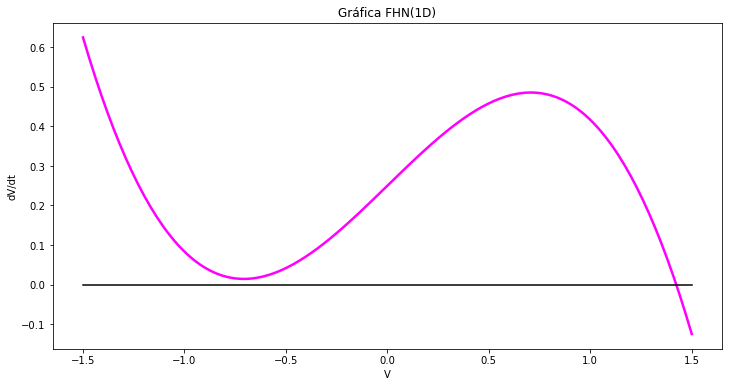

In [32]:
# I1 = -0.3
# I1 = 0.15
I1 = 0.25

def FHN_phase(V):
    return beta*V-V**3/3+I1

V = linspace(-1.5,1.5,201)

p = plt.figure(figsize = (12,6))
p = plt.plot(V,FHN_phase(V), color="magenta", linewidth=2.5)
p = plt.plot([-1.5,1.5],[0.0,0.0],color="black")

# p = plt.scatter([-0.47],[0.0],s=150,color="white",edgecolors="black", linewidth=2.0,alpha=1.0)
# p = plt.scatter([-0.92,1.385],[0.0,0.0],s=150,color="black")

# p = plt.plot([-1.0,-0.3],[-0.1,-0.1],color="red")
# p = plt.plot([-1.0,-0.3],[0.1,0.1],color="red")
# p = plt.plot([-1.0,-1.0],[-0.1,0.1],color="red")
# p = plt.plot([-0.3,-0.3],[-0.1,0.1],color="red")


p = plt.title("Gráfica FHN(1D)")
p = plt.xlabel("V")
p = plt.ylabel("dV/dt")

In [29]:
ZV0 = linspace(-1.5,1.5,21)

pphase = phase(FHN_phase,V0)
pphase = plt.title("Línea fase FHN(1D)")
pphase = plt.xlabel("V")
pphase = plt.ylabel("dV/dt")

TypeError: can't multiply sequence by non-int of type 'float'

<Figure size 864x432 with 0 Axes>

También podemos replicar el fenómeno de *switcheo* de manera ligeramente más sencilla, pues la escala reducida del potencial de membrana implica una reducción de la corriente necesaria para hiperpolarizar cualitativamente a la neurona. Nuevamente, el punto inestable alrededor de $-0.5$ es un umbral que divide las condiciones iniciales que convergen al estado hiperpolarizado y al despolarizado

Text(0, 0.5, 'I')

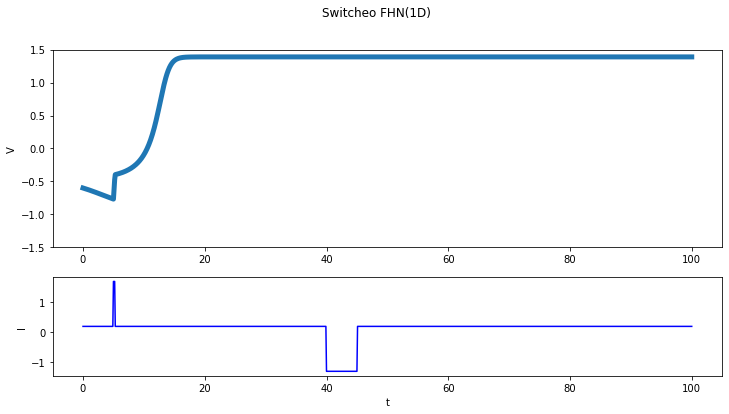

In [34]:
beta = 0.5

def Iapp(t):
    return 0.2+1.5*(t>=5.0 and t<=5.25)+(-0.5)*(t>=40.0 and t<=65.0)

def FHN_app(V,t):
    return beta*V-V**3/3+Iapp(t)

### Integración numérica. Tres soluciones.

t = linspace(0,100,1001)
V0 = -0.6
u = odeint(FHN_app,V0,t)

fig, axs = plt.subplots(2,1,figsize=(12,6), gridspec_kw={'height_ratios': [2,1]})
fig.suptitle("Switcheo FHN(1D)")

axs[0].set_ylabel('V')
axs[0].set_ylim([-1.5,1.5])

axs[0].plot(t,u[:,0],linewidth=5.0)

axs[1].plot(t,graph(t,Iapp),color="blue")
axs[1].set_xlabel('t')
axs[1].set_ylabel('I')    

[Regresar](#intro)

## Tarea 1
<a id='tarea'></a>
<blockquote>

**Ejercicio 1.-** Grafica el comportamiento de los modelos de **Lapicque** y de **IF con fuga** bajo corrientes aplicadas constantes con valores en un intervalo $[0.01,0.1]$ (toma al menos diez valores en dicho rango). Comenta cómo es que varía la evolución del potencial de membrana para distintos valores en este rango. Considera los parámetros $C=1.0$, $g_{\rm L}=0.05$, $E_{\rm L}=4.0$, $V_{th}=5.0$, $V_{\rm reset}=2.0$, $V_{\rm spike}=20.0$.

</blockquote>

<blockquote>
    
**Ejercicio 2.-** Grafica las curvas FI para los dos ejercicios anteriores. ¿Qué diferencias observas? Reporta los valores de corriente aplicada y frecuencia (potenciales de acción/unidad de tiempo) mediante una tabla. No es necesario que implementes un código para calcular la frecuencia. 

</blockquote>

<blockquote>
    
**Ejercicio 3.-** ¿Qué pasa en el modelo IF con fuga cuando $I(t)=0$ y $E>V_{th}$?

</blockquote>

<blockquote>
    
**Ejercicio 4.-** ¿Cómo implementarías, en términos de código o de matemáticas, un período refractario para el modelo IF con fuga?
    
</blockquote>

In [116]:
C = 1.0
g = 0.05
E = 4.0

def LeakIF(t,I,Vth,Vreset,Vspike,r):
    
    V = np.zeros(len(t))
    V[0] = Vreset
    dt = t[1]-t[0]
    N = randn(len(t))
    
    for k in range(len(t)-1):
        
        Vf = V[k]+dt*(I(t[k])-g*(V[k]-E))/C+r*sqrt(dt)*N[k]
        
        if V[k]<=Vth:
            
            V[k+1] = Vf
            
        elif V[k]>Vth and V[k]<Vspike:
            
            V[k+1] = Vspike
            
        elif V[k]>= Vspike:
            
            V[k+1] = Vreset
            
    return [V, N]

Text(0.5, 0, 't')

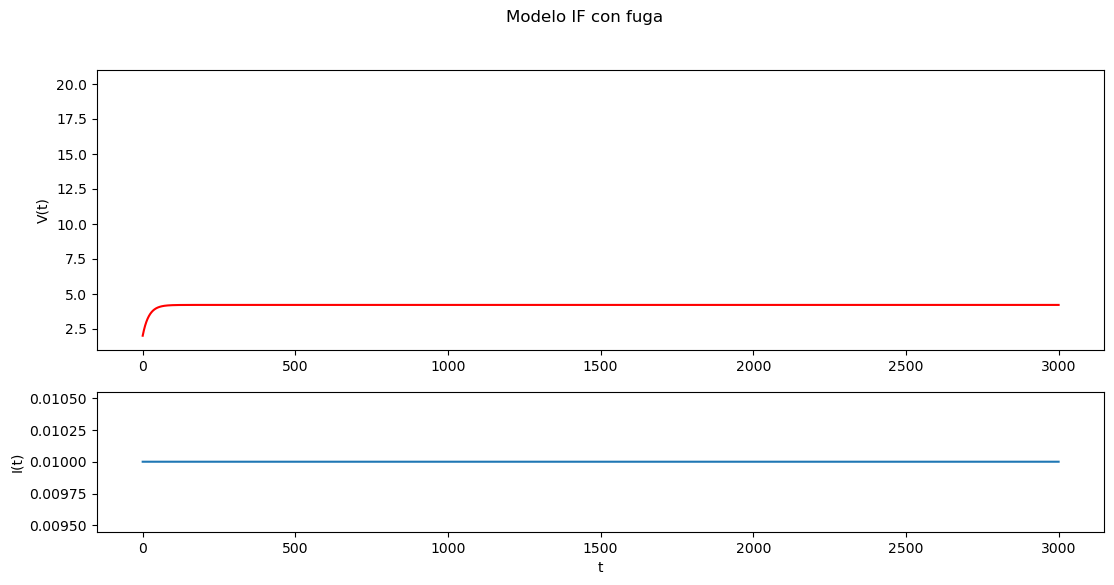

In [130]:
from numpy.random import randn

t = linspace(0,3000,300001)

Vth = 5.0
Vreset = 2.0
Vspike = 20.0

noise_int = 0.0
# noise_int = 0.1
# noise_int = 0.5

I = 0.01

def I5(t):

#     return 0.15                  # Bloques periódicos
    return I                 # Bloques periódicos

V, N = LeakIF(t,I5,Vth,Vreset,Vspike,noise_int)

fig, axs = plt.subplots(2,1,figsize=(13,6), gridspec_kw={'height_ratios': [2,1]})
fig.suptitle("Modelo IF con fuga")

axs[0].plot(t,V,color="red")
axs[0].set_ylim([Vreset-1.0,Vspike+1.0])
axs[0].set_ylabel("V(t)")

axs[1].plot(t,I5(t)+noise_int*N)
axs[1].set_ylabel("I(t)")
axs[1].set_xlabel("t")

In [46]:
C = 1.0                                            # Capacidad eléctrica

# t vector de tiempos
# I corriente aplicada
# Vth umbral
# Vreset reseteo
# Vspike máxima despolarización
# r intensidad del ruido

def LapIF(t,I,Vth,Vreset,Vspike,r):
    
    V = np.zeros(len(t))
    V[0] = Vreset
    dt = t[1]-t[0]
    N = randn(len(t))
    
    for k in range(len(t)-1):
        
        Vi = V[k]
        ti = t[k]
        Vf = V[k]+dt*(I(t[k]))/C+r*sqrt(dt)*N[k]
        
        if Vf<=Vth:
            
            V[k+1] = Vf
            
        elif Vf>Vth and Vf<Vspike:
            
            V[k+1] = Vspike
            
        else:
            
            V[k+1] = Vreset
            
    return [V, N]

Text(0.5, 0, 't')

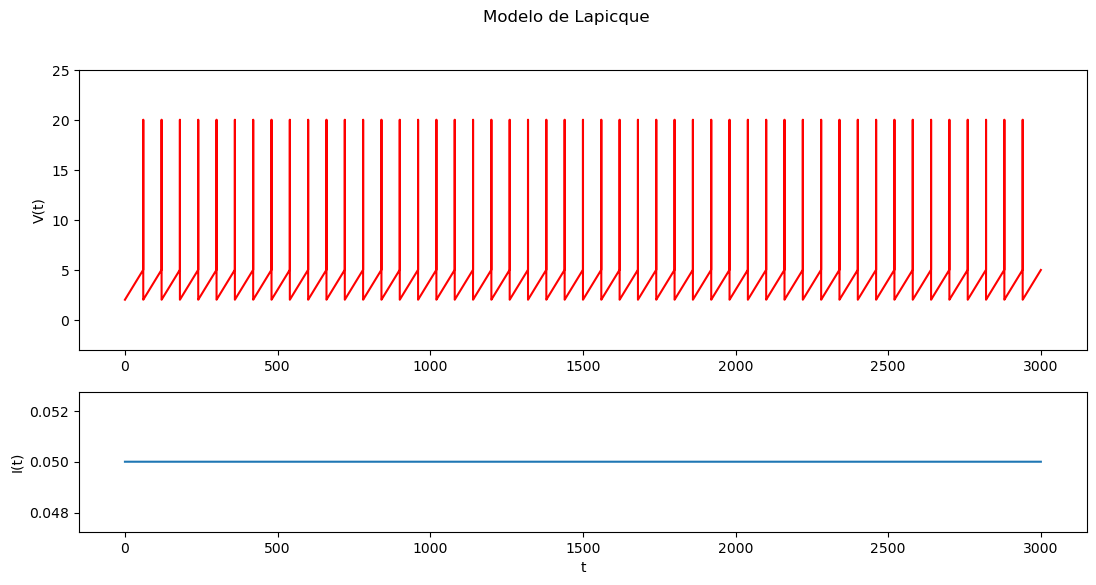

In [129]:
def I1(t):
    return 0.05 # Corriente aplicada

Vth = 5.0
Vreset = 2.0
Vspike = 20.0

noise_int = 0.0
# noise_int = 0.1
# noise_int = 0.5
# noise_int = 1.0

t = linspace(0,3000,300001)

V, N = LapIF(t,I1,Vth,Vreset,Vspike,noise_int)

fig, axs = plt.subplots(2,1,figsize=(13,6), gridspec_kw={'height_ratios': [2,1]})
fig.suptitle("Modelo de Lapicque")

axs[0].plot(t,V,color="red")
axs[0].set_ylim([Vreset-5.0,Vspike+5.0])
axs[0].set_ylabel("V(t)")

axs[1].plot(t,I1(t)+noise_int*N)
axs[1].set_ylabel("I(t)")
axs[1].set_xlabel("t")